In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

import os
import random

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [9, 2]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["agg.path.chunksize"] = 100000
pd.set_option("plotting.backend", "matplotlib")
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

time: 1.25 s (started: 2023-05-24 17:33:31 -04:00)


In [5]:
from pprint import pprint
from numalogic.config import ModelInfo
from omegaconf import OmegaConf
from numalogic.models.autoencoder import AutoencoderTrainer
from numalogic.preprocess import TanhScaler
from benchmarks.kpi.datamodule import KPIDataModule

# KPI index to use
KPI_ID = 14

# Path variables
DATA_FILE_PATH = "data/Finals_dataset/phase2_train.csv"
MODEL_PATH = f"results/kpi_idx_{KPI_ID}/"
MODEL_NAME = "sparsevanilla"

# Load hyperparams file
hyperparams = OmegaConf.load(os.path.join(MODEL_PATH, MODEL_NAME, "hyperparams.json"))
model_schema = OmegaConf.structured(ModelInfo)
model_conf = OmegaConf.merge(model_schema, hyperparams["MODEL"])
pprint(dict(hyperparams), indent=2)

{ 'BATCH_SIZE': 64,
  'MODEL': {'name': 'SparseVanillaAE', 'conf': {'seq_len': 10, 'encoder_layersizes': [16, 32], 'decoder_layersizes': [32, 16]}},
  'SPLIT_RATIOS': [0.5, 0.2, 0.3],
  'TRAINER': {'accelerator': 'cpu', 'max_epochs': 50}}
time: 4.18 ms (started: 2023-05-24 17:36:28 -04:00)


In [7]:
from numalogic.config.factory import ModelFactory

datamodule = KPIDataModule(
    DATA_FILE_PATH,
    KPI_ID,
    [TanhScaler()],
    split_ratios=hyperparams["SPLIT_RATIOS"],
    seq_len=model_conf.conf.seq_len,
    batch_size=hyperparams["BATCH_SIZE"],
)
model = ModelFactory().get_instance(model_conf)

trainer = AutoencoderTrainer(
    **hyperparams["TRAINER"],
    enable_progress_bar=True,
    enable_model_summary=True,
    num_sanity_val_steps=0
)
trainer.fit(model, datamodule=datamodule)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type     | Params
-------------------------------------
0 | encoder | _Encoder | 724   
1 | decoder | _Decoder | 700   
-------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


Using KPI ID: 431a8542-c468-3988-a508-3afd06a218da
Train size: (64524, 1)
Val size: (12904, 1)


2023-05-24 17:36:40,494 - INFO - epoch=0, training_loss=0.04852
2023-05-24 17:36:46,749 - INFO - validation_loss=0.00045
2023-05-24 17:36:48,291 - INFO - epoch=5, training_loss=0.00096
2023-05-24 17:36:54,570 - INFO - validation_loss=0.00172
2023-05-24 17:36:56,143 - INFO - epoch=10, training_loss=0.00076
2023-05-24 17:37:02,462 - INFO - validation_loss=0.00166
2023-05-24 17:37:03,987 - INFO - epoch=15, training_loss=0.00068
2023-05-24 17:37:10,207 - INFO - validation_loss=0.00120
2023-05-24 17:37:11,728 - INFO - epoch=20, training_loss=0.00055
2023-05-24 17:37:17,896 - INFO - validation_loss=0.00095
2023-05-24 17:37:19,404 - INFO - epoch=25, training_loss=0.00050
2023-05-24 17:37:25,668 - INFO - validation_loss=0.00084
2023-05-24 17:37:27,188 - INFO - epoch=30, training_loss=0.00059
2023-05-24 17:37:33,363 - INFO - validation_loss=0.00082
2023-05-24 17:37:34,879 - INFO - epoch=35, training_loss=0.00049
2023-05-24 17:37:41,078 - INFO - validation_loss=0.00046
2023-05-24 17:37:42,596 - 

time: 1min 19s (started: 2023-05-24 17:36:37 -04:00)


In [8]:
# Uncomment the following lines for loading a saved model
# model_cls = ModelFactory().get_cls(model_info=model_conf)
# model = model_cls.load_from_checkpoint(os.path.join(MODEL_PATH, MODEL_NAME, "model2.pth"), **model_conf.conf)
# model.eval()
# datamodule.setup("fit")
# datamodule.setup("predict")

time: 427 µs (started: 2023-05-24 17:38:18 -04:00)


In [9]:
train_reconerr = trainer.predict(model, dataloaders=datamodule.train_dataloader(), unbatch=True).numpy()
val_reconerr = trainer.predict(model, dataloaders=datamodule.val_dataloader(), unbatch=True).numpy()

Test size: (38713, 1)
Test size: (38713, 1)
time: 593 ms (started: 2023-05-24 17:38:19 -04:00)


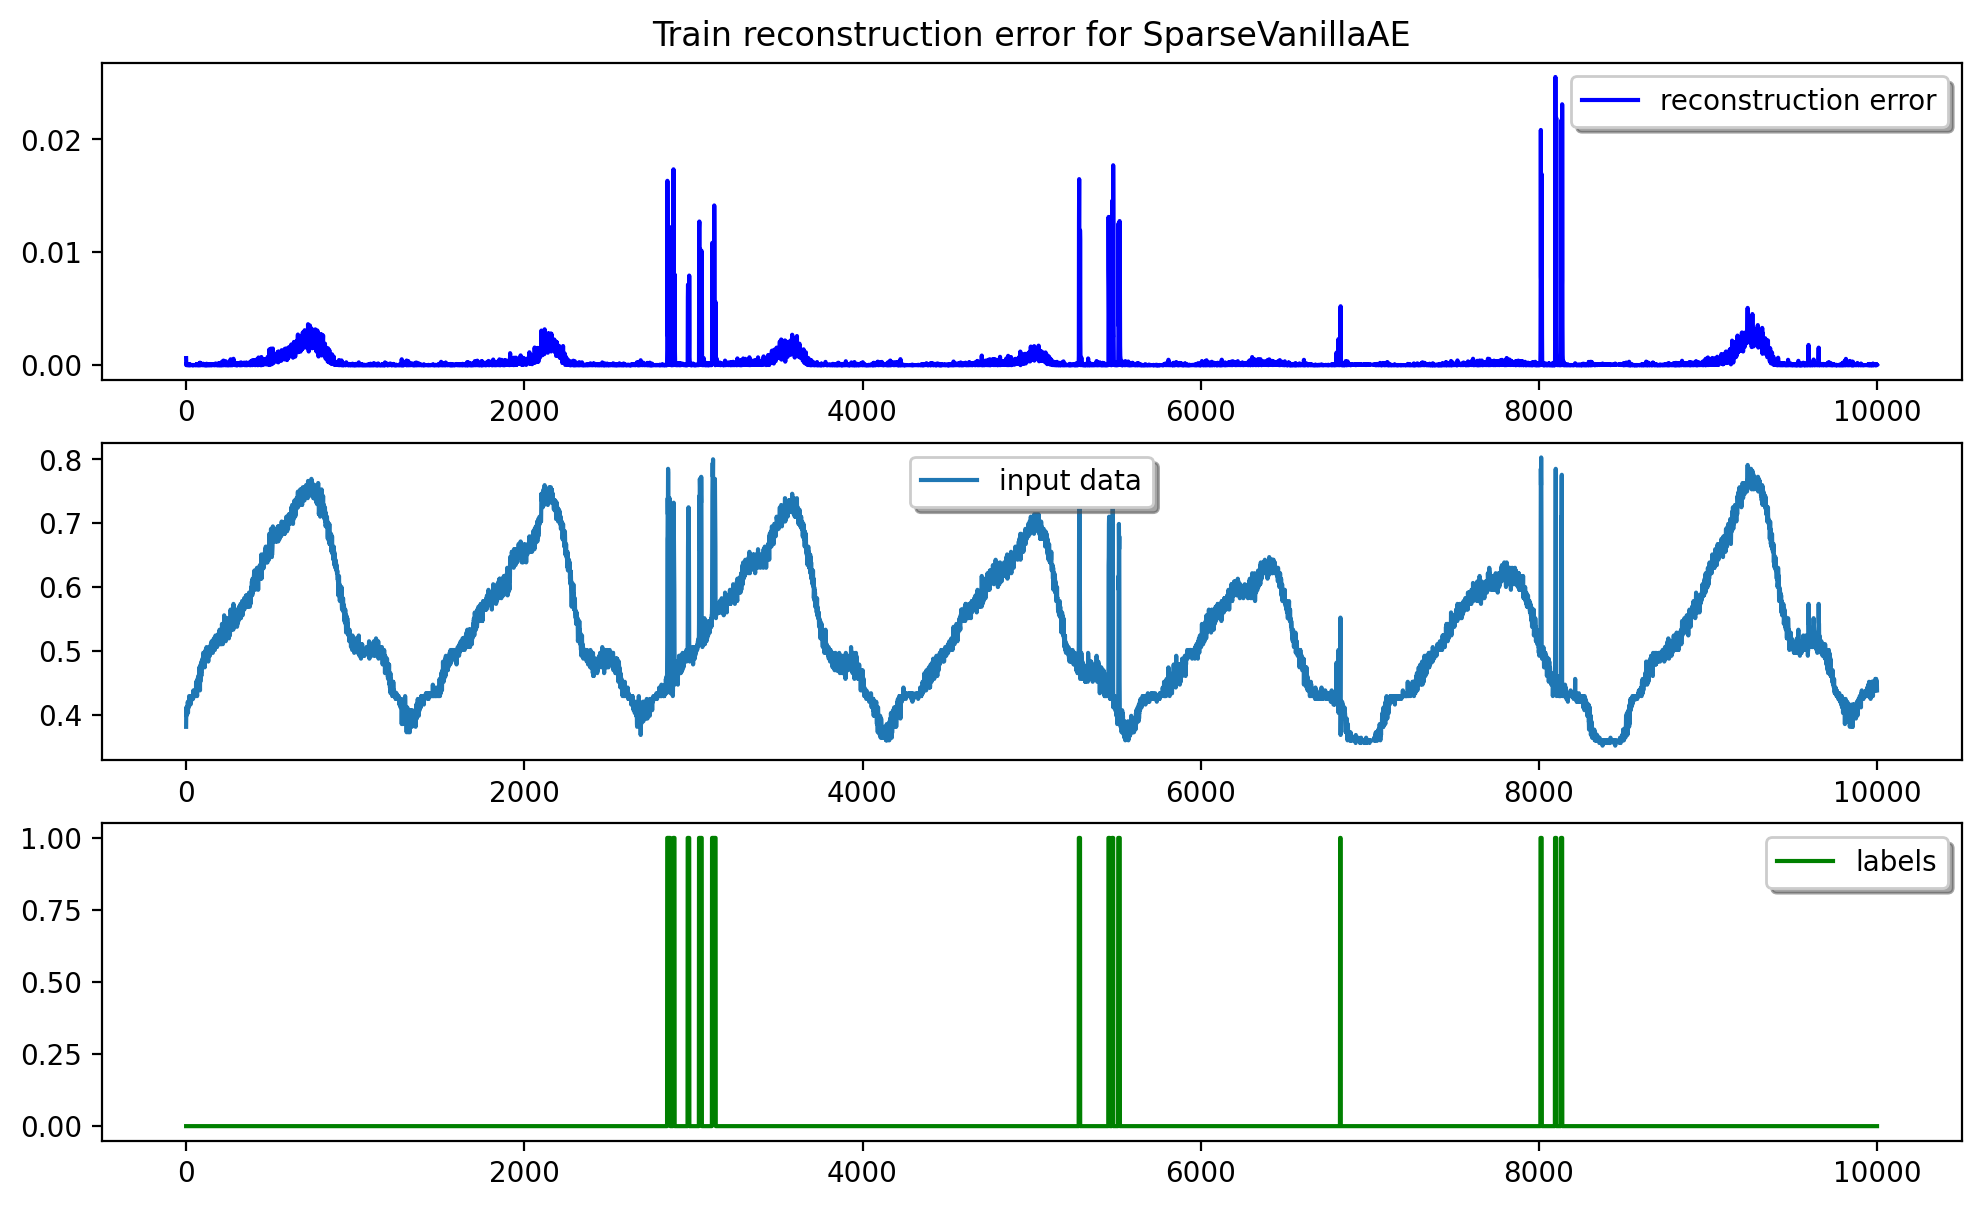

time: 657 ms (started: 2023-05-24 17:38:20 -04:00)


In [10]:
from benchmarks.plots import plot_reconerr_comparision

fig = plot_reconerr_comparision(train_reconerr, datamodule.train_data, datamodule.train_labels, end=10000, title=f"Train reconstruction error for {model_conf.name}")
fig.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "train.png"))

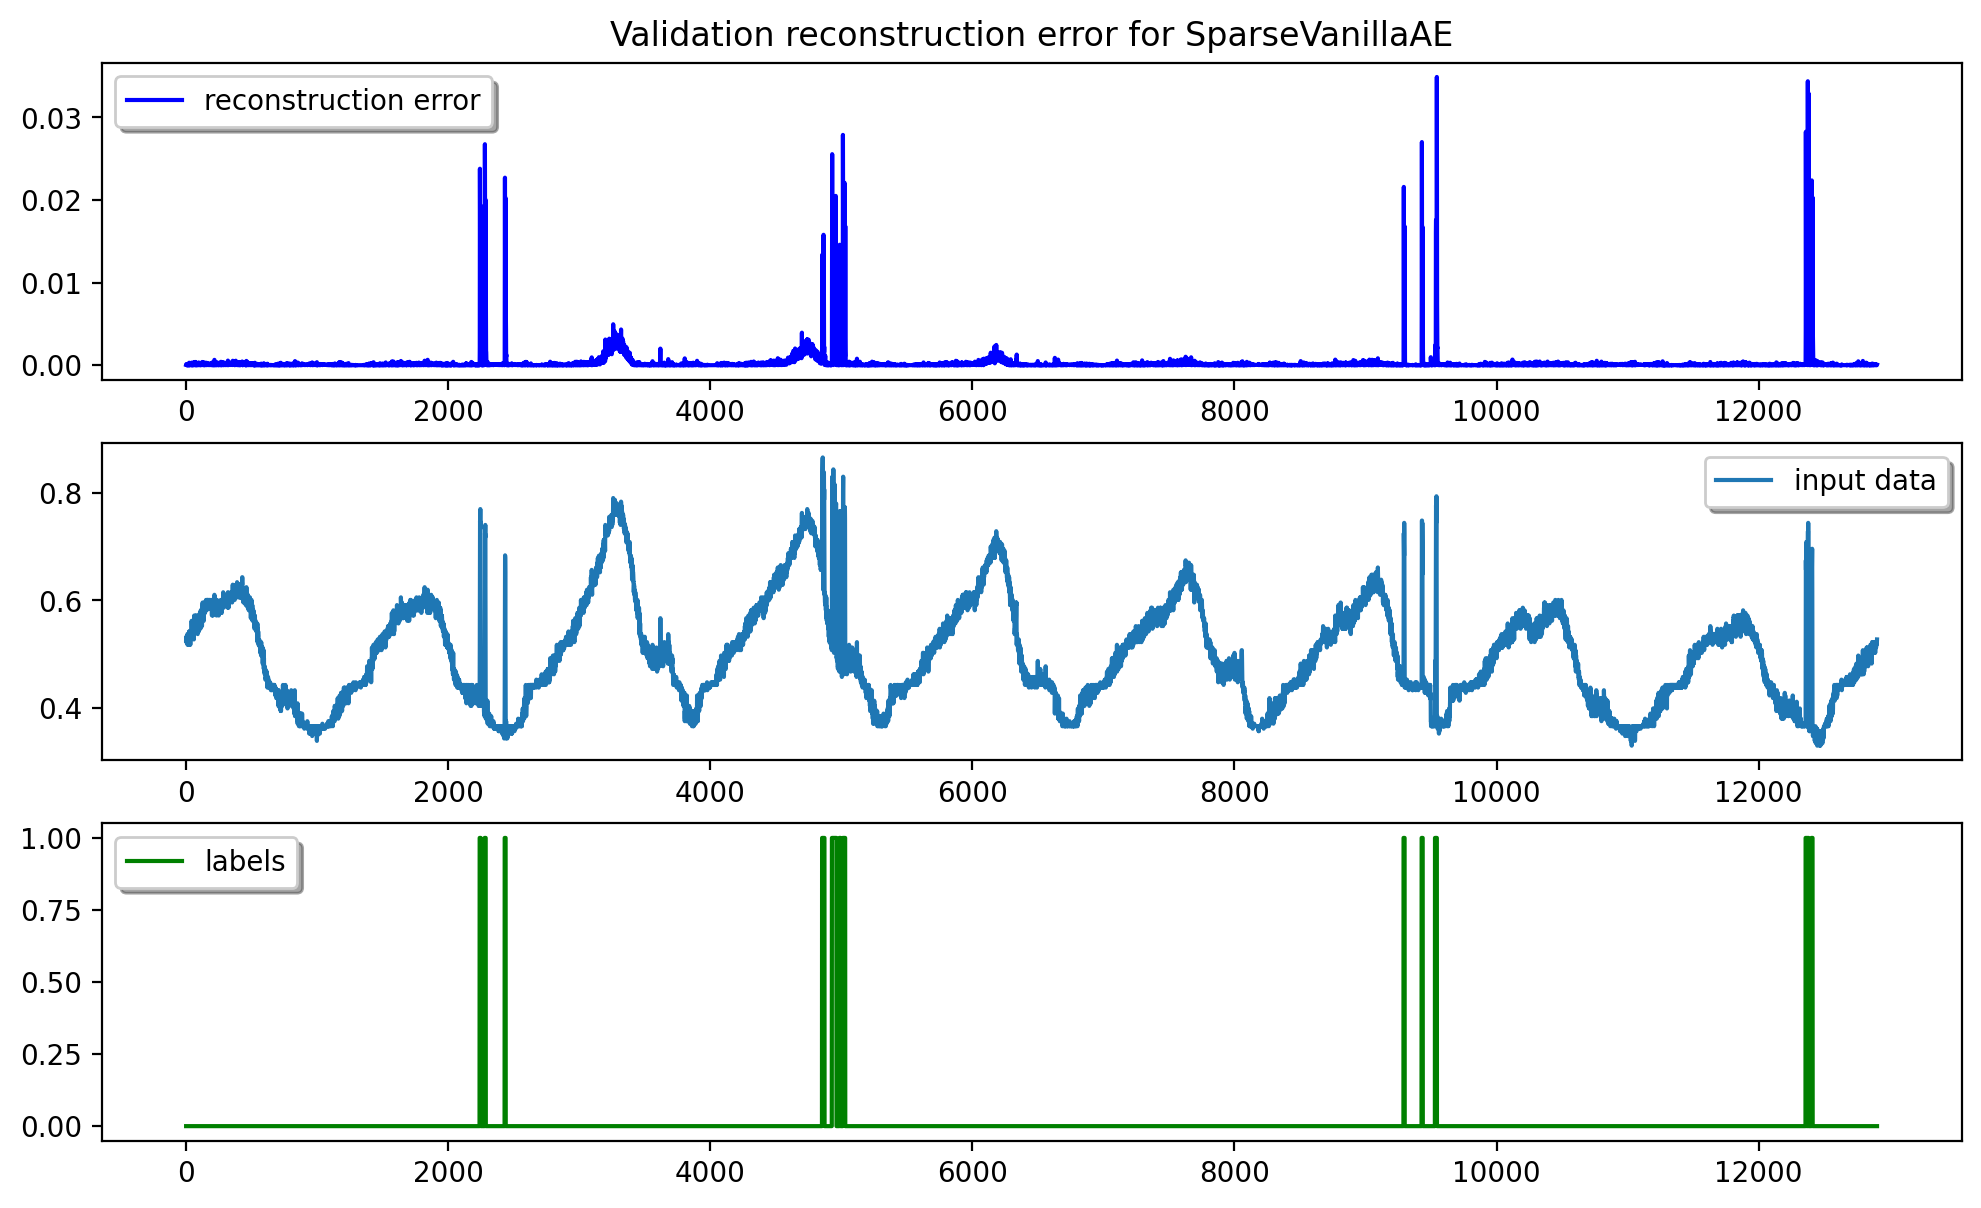

time: 648 ms (started: 2023-05-24 17:38:25 -04:00)


In [11]:
fig = plot_reconerr_comparision(val_reconerr, datamodule.val_data, datamodule.val_labels, title=f"Validation reconstruction error for {model_conf.name}")
fig.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "val.png"))

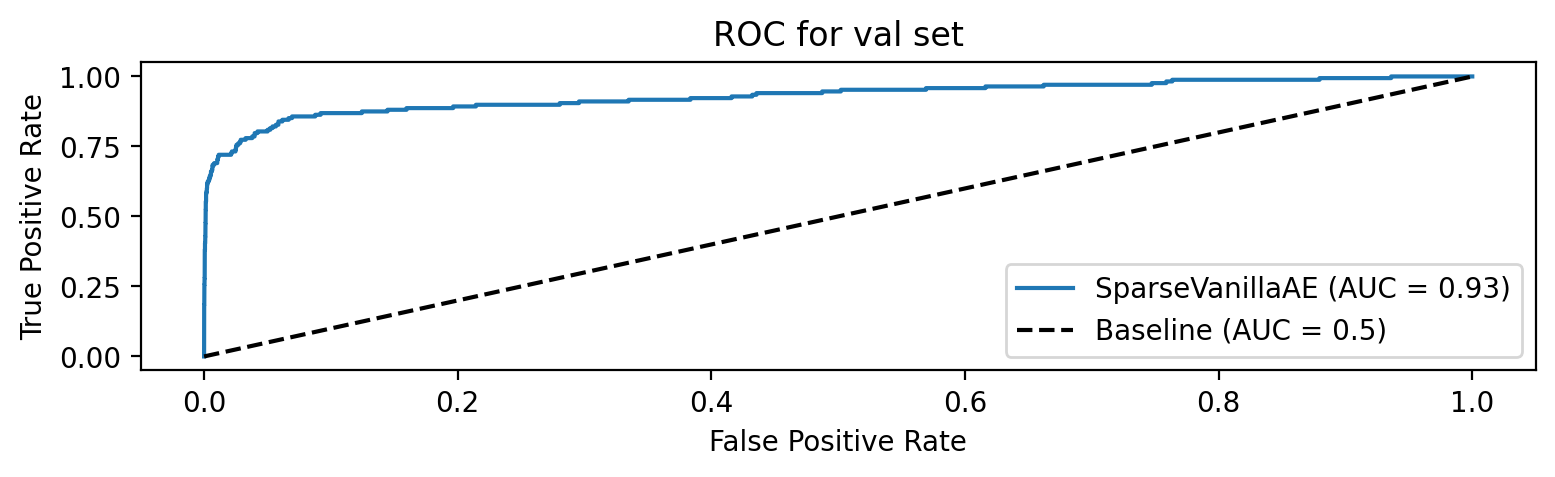

time: 220 ms (started: 2023-05-24 17:38:28 -04:00)


In [12]:
from benchmarks.plots import plot_roc_curve

plot_roc_curve(datamodule.val_labels, val_reconerr, model_conf.name, title="ROC for val set")
plt.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "roc_val.png"), bbox_inches='tight')

Test size: (38713, 1)


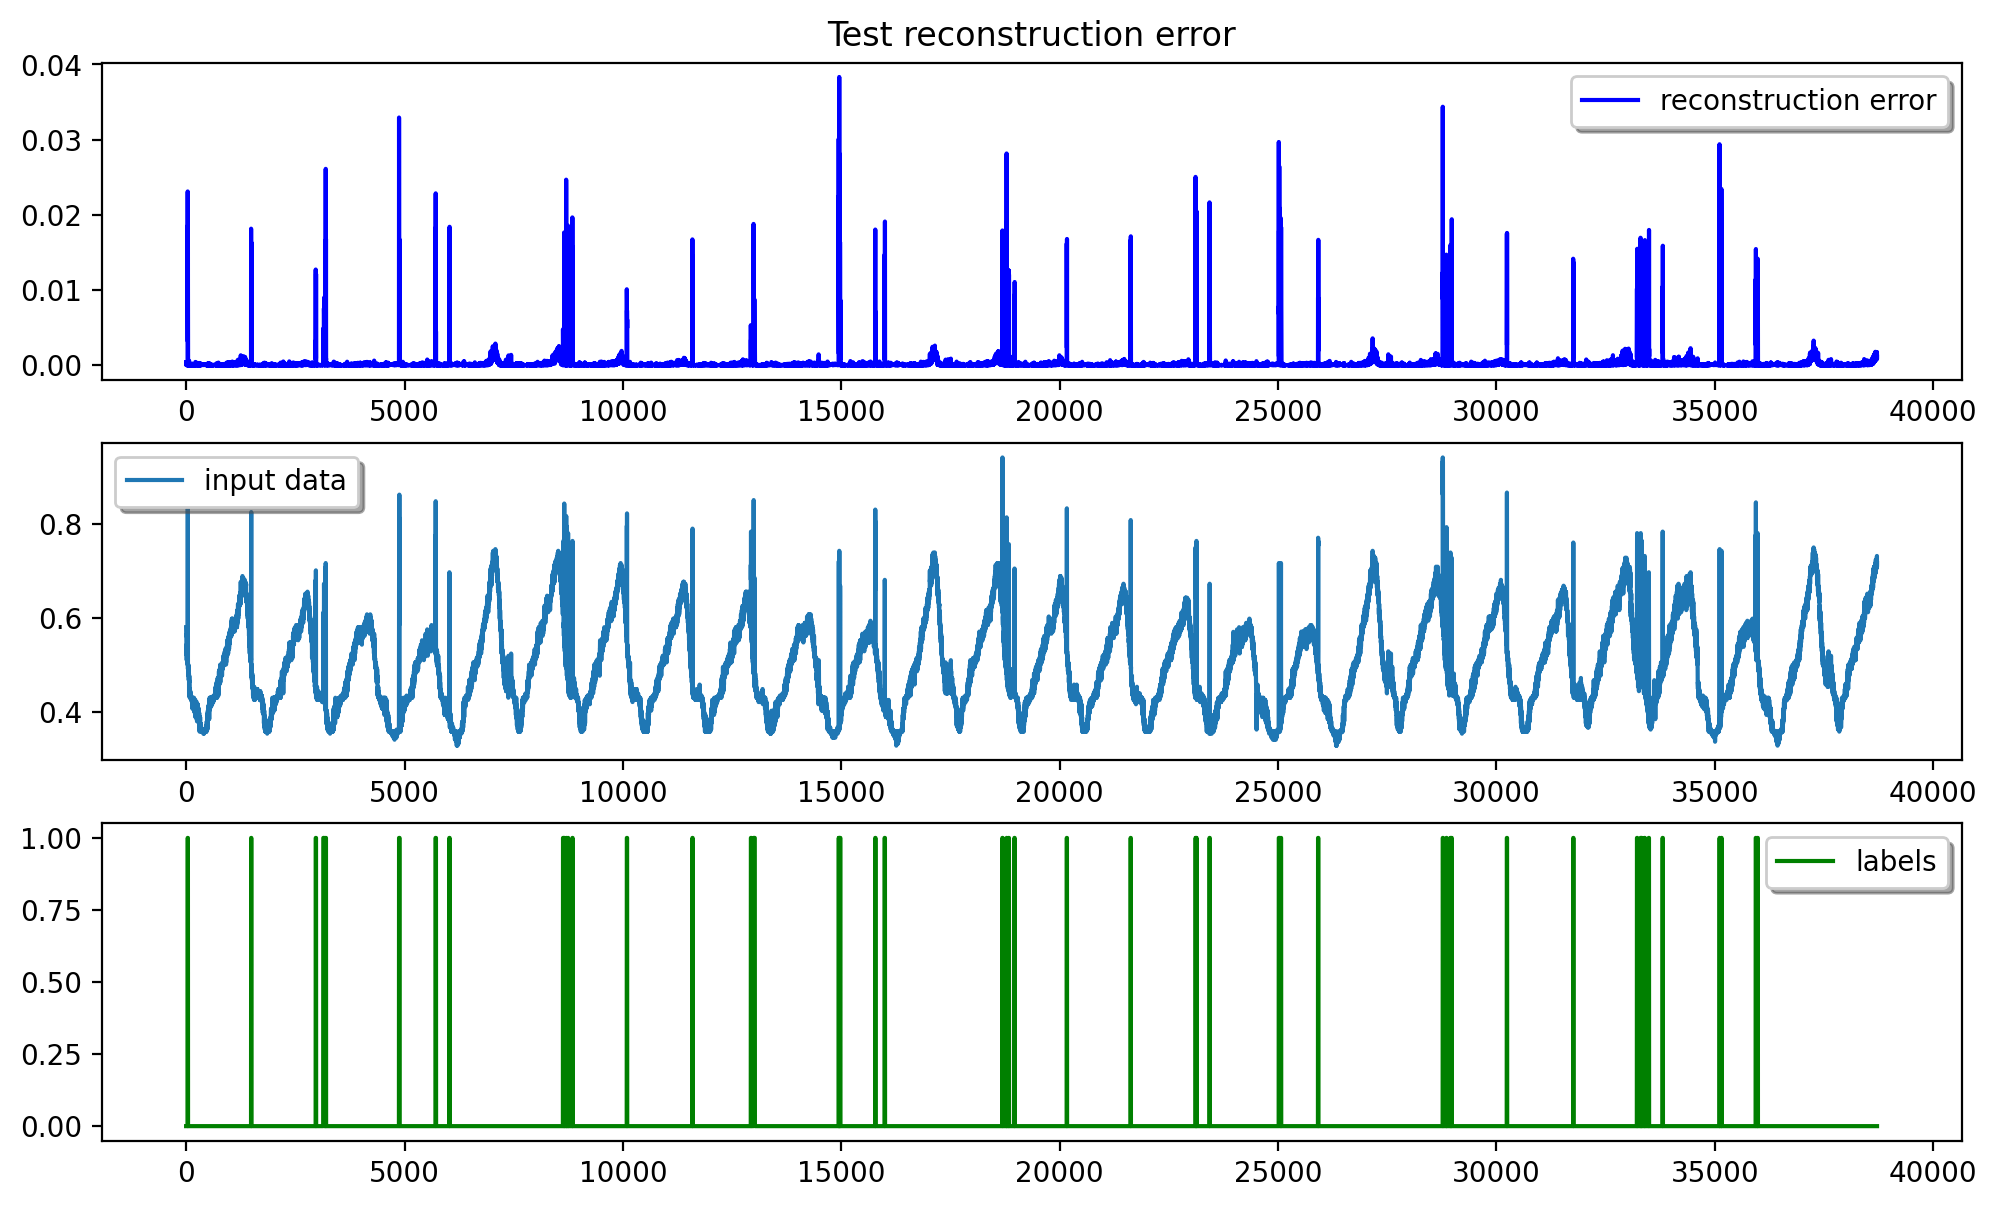

time: 1.13 s (started: 2023-05-24 17:38:34 -04:00)


In [13]:
test_reconerr = trainer.predict(model, dataloaders=datamodule.predict_dataloader()).numpy()
fig = plot_reconerr_comparision(test_reconerr, datamodule.test_data, datamodule.test_labels, title="Test reconstruction error")
fig.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "test.png"))

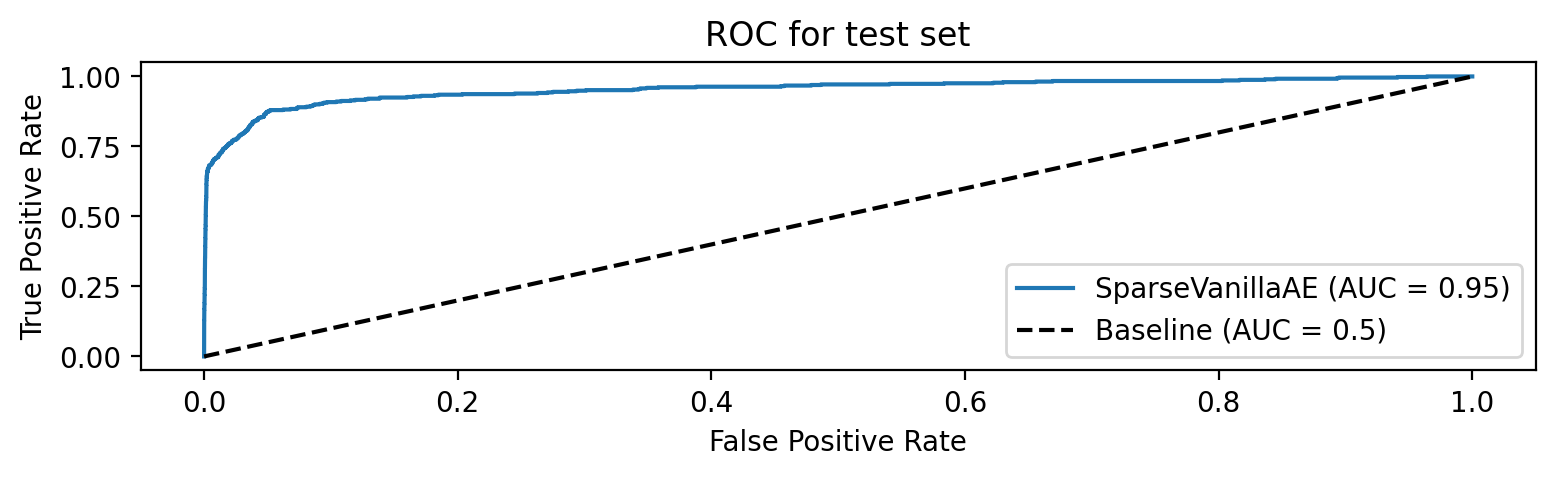

time: 226 ms (started: 2023-05-24 17:38:37 -04:00)


In [14]:
plot_roc_curve(datamodule.test_labels, test_reconerr, model_conf.name, title="ROC for test set")
plt.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "roc_test.png"), bbox_inches='tight')

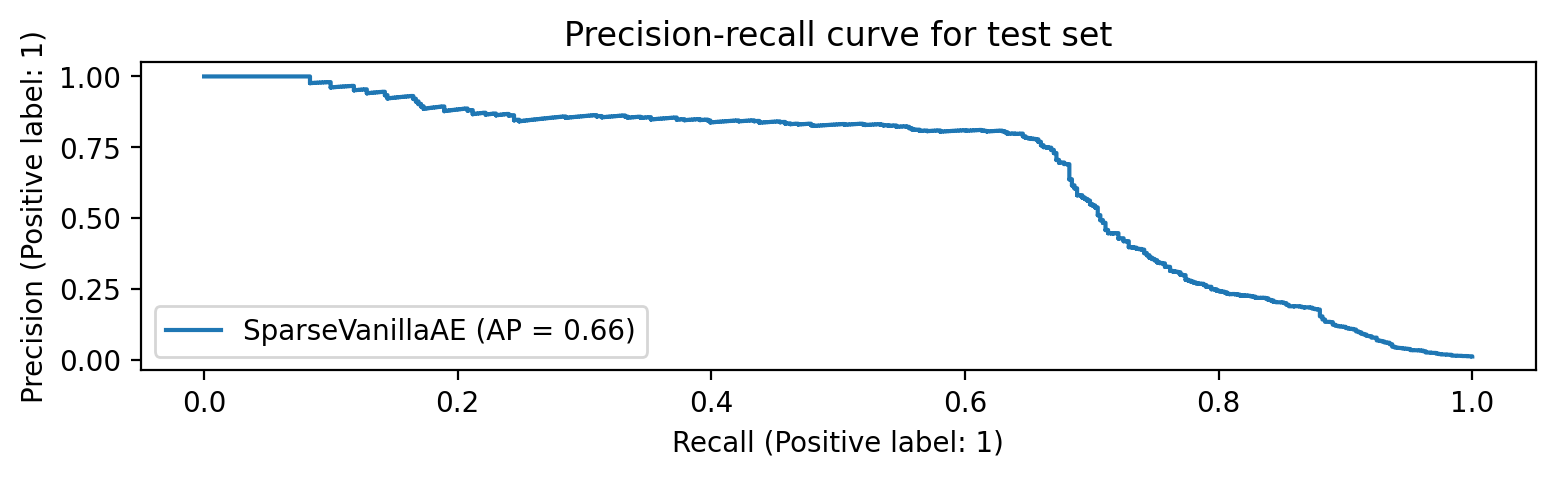

time: 193 ms (started: 2023-05-24 17:38:41 -04:00)


In [15]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(datamodule.test_labels, test_reconerr, name=model_conf.name)
plt.title(f"Precision-recall curve for test set")
plt.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "pr_curve_test.png"))

In [16]:
# Uncomment this to save the model
# trainer.save_checkpoint(os.path.join(MODEL_PATH, MODEL_NAME, "model.pth"))
# print(hyperparams)

time: 421 µs (started: 2023-05-24 17:39:08 -04:00)
